In [1]:
%matplotlib inline
import graphviz
import torch
from matplotlib import pyplot as plt
from matplotlib import transforms
from torch.utils import data
from torch import nn
import matplotlib.cm as plt_cm
import numpy as np
import random
from IPython import display
from d2l import torch as d2l

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

# 线性回归

线性回归是一种回归算法，在[监督式学习](../SupervisedLearning/README.md)已经有讨论过，当时使用矩阵算法来求解。

线性回归可以看作是单层的神经网络

$$y=\boldsymbol{w}^\top\boldsymbol{x}+b$$

下面以神经网络的方式来求解线性回归。

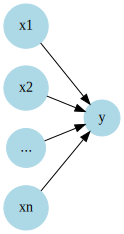

In [2]:
G = graphviz.Digraph()
G.attr("node", shape="circle", style="filled", color="lightblue")
G.attr(rankdir="LR")
G.node("x1", pos="100,200")
G.node("x2", pos="100,150")
G.node("...")
G.node("xn", pos="100,50")
G.node("y")

G.edge("x1", "y"), G.edge("x2", "y"), G.edge("...", "y"), G.edge("xn", "y")
G

## 线性回归的实现

### 生成数据集
首先定义数据集，数据集基于[上帝函数](../SupervisedLearning/theory.ipynb)

$$y=2x_1-3.4x_2+4.2$$

加上一个服从均值$\mu=0$，方差$\sigma^2=0.01$的[正态分布](../SupervisedLearning/theory.ipynb)的噪音

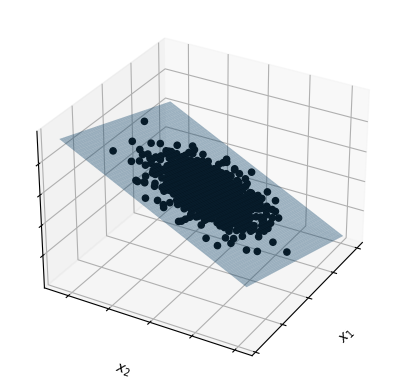

In [3]:
def f(w, b, x):
    return x @  w + b

def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
ax = plt.subplot(projection="3d")
ax.view_init(None, 30, None)
ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])
ax.set_xlabel("$x_1$"), ax.set_ylabel("$x_2$"), ax.set_zlabel("$y$")
ax.scatter(features[:, 0].detach().numpy(), features[:, 1].detach().numpy(), labels, color='k', alpha=1)
x1_min, x1_max = features[:, 0].min() - 0.5, features[:, 0].max() + 0.5
x2_min, x2_max = features[:, 1].min() - 0.5, features[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
Z = np.array(f(true_w.detach().numpy(), true_b, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.plot_surface(xx, yy, Z, alpha=0.4)
plt.show()

### 损失函数
使用平方误差来表达模型的损失，损失函数为

$$l(y, \hat{y})=\frac{1}{2}(\hat{y}-y)^2$$

那么训练集带来的总的误差为

$$L(\boldsymbol{w}, b)=\frac{1}{2n}\sum_{i=1}^{n}(\boldsymbol{w}^\top\boldsymbol{x}^{(i)}+b-y^{(i)})^2$$

那么模型的参数为

$$\boldsymbol{w^*}, b^*=\operatorname*{argmin}_{\boldsymbol{w}, b}L(\boldsymbol{w}, b)$$

In [4]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 小批量随机梯度下降

在监督式学习中已经通过梯度下降和及其变种随机梯度下降来解决[逻辑回归](../SupervisedLearning/logistic_regression.ipynb)的问题。
小批量随机梯度下降和随机梯度下降基本原理差不多，只是随机梯度下降是在单个样本上计算梯度，而小批量随机梯度下降是在一个批量(batch)上计算梯度。

In [5]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad(): # 参数迭代时不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size # 由于损失函数没有除以batch_size，这里需要除
            param.grad.zero_()

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

### 训练
训练的逻辑比较简单，步骤为
- 初始化模型、模型参数
- 遍历数据集，应用小批量梯度下降更新参数
- 重复步骤2，直至epoch结束

In [6]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(w, b)


epoch 1, loss 0.029360
epoch 2, loss 0.000119
epoch 3, loss 0.000053
tensor([[ 1.9995],
        [-3.3992]], requires_grad=True) tensor([4.1992], requires_grad=True)


## 基于PyTorch的线性回归实现

### 读取数据集
使用PyTorch的[Dataset & DataLoader](https://pytorch.org/docs/stable/data.html)读取数据集

In [7]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

### 定义模型

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)是一个容器，内部有多个模型嵌套在一起构成一个网络结构，[`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)表示线性模型。

使用`nn.Sequential`和`nn.Linear`定义模型，并将模型参数重置。

In [8]:
net = nn.Sequential(nn.Linear(2, 1))
x = torch.randn(1, 2)
y = net(x)
print(f"x={x}, y={y}, expect={x@net[0].weight.data.T+net[0].bias.data}")

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

x=tensor([[-0.3823,  0.3118]]), y=tensor([[-0.4999]], grad_fn=<AddmmBackward0>), expect=tensor([[-0.4999]])


tensor([0.])

### 损失函数
使用[`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)作为平方误差损失函数。

In [9]:
loss = nn.MSELoss()
y_true = torch.randn(10, 1)
y_pred = torch.randn(10, 1)
print(f"loss={loss(y_pred, y_true)}, expect={((y_true - y_pred)**2).mean()}")

loss=4.286417007446289, expect=4.286417007446289


### 训练

In [10]:
num_epochs = 3
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
batch_size = 10
data_iter = load_array((features, labels), batch_size)
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000213
epoch 2, loss 0.000106
epoch 3, loss 0.000106


## 课后习题
- 假设我们有一些数据$x_1, \cdots, x_n \in \mathbb{R}$。我们的目标是找到一个常数$b$，使得最小化$\sum_i(x_i-b)^2$。
    - 找到最优值$b$的解析解。
    - 这个问题及其解与正态分布有什么关系?

    定义函数
    $$f=\sum_{i=1}^n(x_i-b)^2$$

    对$b$求导可得
    
    $$\frac{d}{db}f=-2(\sum_{i=1}^{n}x_i-nb)$$

    因此
    
    $$b=\frac{2}{n}\sum_{i=1}^{n}x_i=2\bar{x}$$

    $b$服从

    $$b \sim N(\bar{x}, 0)$$

- 推导出使用平方误差的线性回归优化问题的解析解。为了简化问题，可以忽略偏置$b$（我们可以通过向$\boldsymbol{X}$添加所有值为1的一列来做到这一点）。

    - 用矩阵和向量表示法写出优化问题（将所有数据视为单个矩阵，将所有目标值视为单个向量）。
    - 计算损失对$\boldsymbol{w}$的梯度。
    - 通过将梯度设为0、求解矩阵方程来找到解析解。
    - 什么时候可能比使用随机梯度下降更好？这种方法何时会失效？

    线性回归模型为

    $$y=\boldsymbol{w}^\top\boldsymbol{x}+b$$
    
    其中

    $$
    \boldsymbol{w}=\begin{bmatrix}
    w_1 \\
    \vdots \\
    w_n
    \end{bmatrix} \quad, \boldsymbol{x}=\begin{bmatrix}
    x_1 \\
    \vdots \\
    x_n
    \end{bmatrix}
    $$

    令
    $$
    \boldsymbol{w}=\begin{bmatrix}
    b \\
    w_1 \\
    \vdots \\
    w_n
    \end{bmatrix} \quad, \boldsymbol{x}=\begin{bmatrix}
    1 \\
    x_1 \\
    \vdots \\
    x_n
    \end{bmatrix}
    $$

    那么线性回归的模型可以改写为

    $$y=\boldsymbol{w}^\top\boldsymbol{x}$$

    损失函数就可以改写为
    
    $$\begin{aligned}
    L(\boldsymbol{w}) &= \frac{1}{2n}\sum_{i=1}^{n}(\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-y^{(i)})^2 \\
    &= \frac{1}{2n}\begin{bmatrix}
    \boldsymbol{w}^\top\boldsymbol{x}^{(1)} \cdots \boldsymbol{w}^\top\boldsymbol{x}^{(n)}
    \end{bmatrix}
    \begin{bmatrix}
    \boldsymbol{w}^\top\boldsymbol{x}^{(1)} \\
    \vdots \\
    \boldsymbol{w}^\top\boldsymbol{x}^{(n)}
    \end{bmatrix} \\
    \end{aligned}$$

    令

    $$\begin{aligned}\boldsymbol{A} &= \begin{bmatrix}
    \boldsymbol{w}^\top\boldsymbol{x}^{(1)}-y^{(1)} \cdots \boldsymbol{w}^\top\boldsymbol{x}^{(n)}-y^{(n)}
    \end{bmatrix} \\\\
    &= \begin{bmatrix} \boldsymbol{w}^\top\boldsymbol{x}^{(1)} \cdots \boldsymbol{w}^\top\boldsymbol{x}^{(n)} \end{bmatrix}-\begin{bmatrix} 
    y^{(1)} \cdots y^{(n)} \end{bmatrix}\\\\
    &= \boldsymbol{w}^\top\begin{bmatrix}\boldsymbol{x}^{(1)} \cdots \boldsymbol{x}^{(n)}\end{bmatrix}-\begin{bmatrix} y^{(1)} \cdots y^{(n)}\end{bmatrix} \\\\
    &= \boldsymbol{w}^\top\boldsymbol{X}^\top-\boldsymbol{Y}^\top
    \end{aligned}$$

    损失函数从而可以继续改写

    $$\begin{aligned}
    L(\boldsymbol{w}) &= \frac{1}{2n}\boldsymbol{A}\boldsymbol{A}^\top \\\\
    &= \frac{1}{2n}(\boldsymbol{w}^\top\boldsymbol{X}^\top-\boldsymbol{Y}^\top)(\boldsymbol{w}^\top\boldsymbol{X}^\top-\boldsymbol{Y}^\top)^\top \\\\
    &= \frac{1}{2n}(\boldsymbol{w}^\top\boldsymbol{X}^\top-\boldsymbol{Y}^\top)(\boldsymbol{X}\boldsymbol{w}-\boldsymbol{Y}) \\\\
    &= \frac{1}{2n}(\boldsymbol{w}^\top\boldsymbol{X}^\top\boldsymbol{w}\boldsymbol{X}-2\boldsymbol{w}^\top\boldsymbol{X}^\top\boldsymbol{Y}+\boldsymbol{Y}^\top\boldsymbol{Y})
    \end{aligned}$$

    对$\boldsymbol{w}$求导

    $$\begin{aligned}
    \frac{d}{d\boldsymbol{w}}L(\boldsymbol{w}) &=\frac{1}{n}\boldsymbol{X}^\top\boldsymbol{X}\boldsymbol{w}-\frac{1}{n}\boldsymbol{X}^\top\boldsymbol{Y} \\\\
    &= \frac{1}{n}(\boldsymbol{X}^\top\boldsymbol{X}\boldsymbol{w}-\boldsymbol{X}^\top\boldsymbol{Y})
    \end{aligned}$$

    如果$\boldsymbol{X}$可逆，那么解析解为

    $$\boldsymbol{w}^{*}=(\boldsymbol{X}^\top\boldsymbol{X})^{(-1)}\boldsymbol{X}^\top\boldsymbol{Y}$$

- 假定控制附加噪声$\epsilon$的噪声模型是指数分布。也就是说，$p(\epsilon)=\frac{1}{2}exp(-|\epsilon|)$
 
    - 写出模型$-logP(\boldsymbol{y}|\boldsymbol{X})$下数据的负对数似然。
    - 请试着写出解析解。
    - 提出一种随机梯度下降算法来解决这个问题。哪里可能出错？（提示：当我们不断更新参数时，在驻点附近会发生什么情况）请尝试解决这个问题。

    $$p(y|\boldsymbol{x})=\frac{1}{2}exp(-|y-\boldsymbol{w}^\top\boldsymbol{x}-b|)$$

    根据极大似然估计法

    $$\begin{aligned}
    P(\boldsymbol{y}|\boldsymbol{X}) &= \prod_{i=1}^{n}p(y^{(i)}|\boldsymbol{x}^{(i)}) \\\\
    &= \prod_{i=1}^{n}(\frac{1}{2}exp(-|y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b|)) \\\\
    &= \frac{1}{2^n}exp(-\sum_{i=1}^{n}|y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b|)
    \end{aligned}$$

    得到负对数似然

    $$
    \begin{aligned}
    -logP(\boldsymbol{y}|\boldsymbol{X}) &= nlog2 + \sum_{i=1}^{n}|y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b|
    \end{aligned}
    $$

    由于负对数似然包含绝对值，是不可导的，因此没有解析解。

    损失函数为

    $$L(\boldsymbol{w}, b)=nlog2 + \sum_{i=1}^{n}|y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b|$$

    计算梯度
    $$\begin{aligned}
    \frac{\partial (L)}{\partial (\boldsymbol{w})} &= -\sum_{i=1}^{n}\boldsymbol{x}^{(i)}sign(y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b) \\\\
    
    \frac{\partial (L)}{\partial (b)} &= -\sum_{i=1}^{n}sign(y^{(i)}-\boldsymbol{w}^\top\boldsymbol{x}^{(i)}-b)
    \end{aligned}$$

    其中$sign(x)$为[符号函数](../SupervisedLearning/perceptron.ipynb)。

    下面我们以[`nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)为损失函数

    $$
    l_n=|x^{(n)}-y^{(n)}|
    $$

    看下使用梯度下降法来寻找最优解，观察损失的迭代，当`batch_size=1`时，由于每个batch都重新计算梯度，那么梯度有可能在-1和1震荡，因此`loss`也会震荡，而当`batch_size=10`时，由于每个batch都会计算平均的梯度，那么梯度可能是平滑的下降，因此`loss`会收敛。

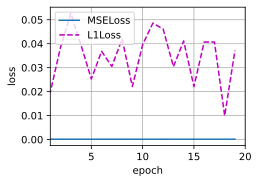

In [11]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5), n = None):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def init_plot_data(self, n):
        if not self.X:
            self.X = []
        if not self.Y:
            self.Y = []
        if n > len(self.X):
            self.X += [[] for _ in range(n - len(self.X))]
        if n > len(self.Y):
            self.Y += [[] for _ in range(n - len(self.Y))]

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    
    def add_with_index(self, x, y, i):
        self.init_plot_data(i + 1)
        # print("after init:", i, len(X))
        self.X[i].append(x)
        self.Y[i].append(y)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

num_epochs = 20
animator = Animator(xlabel="epoch", ylabel="loss", xlim=[1, num_epochs], legend=["MSELoss", "L1Loss"])
batch_size = 1
data_iter = load_array((features, labels), batch_size)
    
def linear_regression_train(loss, idx):
    for module in net.modules():
        for param in module.parameters():
            param.data.fill_(0)
    trainer = torch.optim.SGD(net.parameters(), lr=0.02)
    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X) ,y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
        l = loss(net(features), labels)
        animator.add_with_index(epoch, l.item(), idx)

loss_fns = [nn.MSELoss(), nn.L1Loss()]
for i, loss in enumerate(loss_fns):
    linear_regression_train(loss, i)

- 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？

    前面已经计算过对$\boldsymbol{w}$求导，即使将$\boldsymbol{w}$初始化为0，算法仍然有效。

    但是如果包含一个以上的线性层层，那么权重无法学习。如下是包含两个线性层的`nn.Sequential`，由于

    $$\frac{\partial L}{\partial w}=0$$

    因此$w$始终无法更新。

    其本质是因为每一层的神经元具有同样的输入，并且由于初始$\boldsymbol{w}$和$b$都一样，以你同一层的参数的梯度都一样，因此同一层的参数都一样。

In [12]:
nets = (nn.Sequential(nn.Linear(2, 1)), nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 1)))
num_epochs = 3
for net in nets:
    for module in net.modules():
        for param in module.parameters():
            param.data.fill_(0)
    trainer = torch.optim.SGD(net.parameters(), lr=0.03)
    batch_size = 10
    data_iter = load_array((features, labels), batch_size)
    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X) ,y)
            trainer.zero_grad()
            l.backward()
            # for param in net.parameters():
                # print(param.grad)
            trainer.step()
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')
    for param in net.parameters():
        print(param)
    print("="* 16)

epoch 1, loss 2.712603
epoch 2, loss 0.578093
epoch 3, loss 0.022298
Parameter containing:
tensor([[ 2.0157, -3.4153]], requires_grad=True)
Parameter containing:
tensor([4.1880], requires_grad=True)
epoch 1, loss 3.877364
epoch 2, loss 3.465651
epoch 3, loss 3.316276
Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([[0., 0.]], requires_grad=True)
Parameter containing:
tensor([3.5280], requires_grad=True)


- 为什么在squared_loss函数中需要使用reshape函数？

    `reshape`是保证`y`和`y_hat`有一样的形状，避免发生广播现象，下面的示例，由于缺失`reshape`，发生广播现象，导致结果是一个$3\times 3$的矩阵。

In [13]:
y_true = torch.tensor([1, 2, 3])
y_pred = torch.tensor([4, 5, 6])
y_pred = y_pred.reshape(-1, 1)
(y_pred - y_true)**2/2

tensor([[ 4.5000,  2.0000,  0.5000],
        [ 8.0000,  4.5000,  2.0000],
        [12.5000,  8.0000,  4.5000]])